一、准备数据
imdb数据集的目标是根据电影评论的文本内容预测评论的情感标签。

训练集有20000条电影评论文本，测试集有5000条电影评论文本，其中正面评论和负面评论都各占一半。

文本数据预处理较为繁琐，包括中文切词（本示例不涉及），构建词典，编码转换，序列填充，构建数据管道等等。

在torch中预处理文本数据一般使用torchtext或者自定义Dataset，torchtext功能非常强大，可以构建文本分类，序列标注，问答模型，机器翻译等NLP任务的数据集。

下面仅演示使用它来构建文本分类数据集的方法。

较完整的教程可以参考以下知乎文章：《pytorch学习笔记—Torchtext》

https://zhuanlan.zhihu.com/p/65833208

torchtext常见API一览

torchtext.data.Example : 用来表示一个样本，数据和标签

torchtext.vocab.Vocab: 词汇表，可以导入一些预训练词向量

torchtext.data.Datasets: 数据集类，__getitem__返回 Example实例, torchtext.data.TabularDataset是其子类。

torchtext.data.Field : 用来定义字段的处理方法（文本字段，标签字段）创建 Example时的 预处理，batch 时的一些处理操作。

torchtext.data.Iterator: 迭代器，用来生成 batch

torchtext.datasets: 包含了常见的数据集.

In [17]:
import torch
import torchtext
import string
import re

MAX_WORDS = 10000  # 仅考虑最高频的10000 个词
MAX_LEN = 200 # 每个样本保留200个词的长度
BATCH_SIZE = 20

#分词方法
tokenizer =  lambda x: re.sub(f'[{string.punctuation}]', '', x).split(' ')

# 过滤掉低频词汇
def filter_low_freq_words(arr, vocab):
    arr = [[x if x < MAX_WORDS else 0 for x in example] for example in arr]
    return arr

#1. 定义各个字段的预处理方法
TEXT =  torchtext.data.Field(sequential=True, tokenize=tokenizer, lower=True, fix_length=MAX_LEN, postprocessing=filter_low_freq_words)
LABEL = torchtext.data.Field(sequential=False, use_vocab=False)

#2. 构建表格型dataset
# torchtext.data.TabularDataset 可读去csv, tsv, json 等格式
ds_train, ds_test = torchtext.data.TabularDataset.splits(
    path='./data/imdb', train='train.tsv', test='test.tsv', format='tsv',
    fields=[('label', LABEL), ('text', TEXT)], skip_header=False
)

#3. 构建词典
TEXT.build_vocab(ds_train)

#4. 构建数据管道迭代器
train_iter, test_iter = torchtext.data.Iterator.splits(
    (ds_train, ds_test), sort_within_batch=True, sort_key=lambda x : len(x.text),
    batch_sizes=(BATCH_SIZE, BATCH_SIZE)
)

In [18]:
# 查看example 信息
print(ds_train[0].text)
print(ds_test[0].text)

['it', 'really', 'boggles', 'my', 'mind', 'when', 'someone', 'comes', 'across', 'a', 'movie', 'like', 'this', 'and', 'claims', 'it', 'to', 'be', 'one', 'of', 'the', 'worst', 'slasher', 'films', 'out', 'there', 'this', 'is', 'by', 'far', 'not', 'one', 'of', 'the', 'worst', 'out', 'there', 'still', 'not', 'a', 'good', 'movie', 'but', 'not', 'the', 'worst', 'nonetheless', 'go', 'see', 'something', 'like', 'death', 'nurse', 'or', 'blood', 'lake', 'and', 'then', 'come', 'back', 'to', 'me', 'and', 'tell', 'me', 'if', 'you', 'think', 'the', 'night', 'brings', 'charlie', 'is', 'the', 'worst', 'the', 'film', 'has', 'decent', 'camera', 'work', 'and', 'editing', 'which', 'is', 'way', 'more', 'than', 'i', 'can', 'say', 'for', 'many', 'more', 'extremely', 'obscure', 'slasher', 'filmsbr', 'br', 'the', 'film', 'doesnt', 'deliver', 'on', 'the', 'onscreen', 'deaths', 'theres', 'one', 'death', 'where', 'you', 'see', 'his', 'pruning', 'saw', 'rip', 'into', 'a', 'neck', 'but', 'all', 'other', 'deaths', 'a

In [19]:
# 查看字典信息
print(len(TEXT.vocab))

# itos: index to string
print(TEXT.vocab.itos[0])
print(TEXT.vocab.itos[1])

#stoi: string to index
print(TEXT.vocab.stoi['<unk>'])  # unknown 未知词
print(TEXT.vocab.stoi['<pad>'])  # padding 填充

#freqs : 词频
print(TEXT.vocab.freqs['<unk>'])
print(TEXT.vocab.freqs['a'])
print(TEXT.vocab.freqs['good'])

108197
<unk>
<pad>
0
1
0
129453
11457


In [20]:
# 查看数据管道信息
# 主要有坑: text 第0 维是句子长度


for batch in train_iter:
    features = batch.text
    labels = batch.label
    print(features)
    print(features.shape)
    print(labels)
    break

tensor([[ 876,    2,  126,  ...,   29,  211,   11],
        [  39,  756,  955,  ..., 3414, 1993,   18],
        [  10,   37, 1005,  ...,   88,    2,    7],
        ...,
        [ 117,    2,   70,  ...,    1,    1,    1],
        [   9,   18,   28,  ...,    1,    1,    1],
        [  16,   48,  109,  ...,    1,    1,    1]])
torch.Size([200, 20])
tensor([0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1])


In [21]:
# 将数据管道组织成torch.utiles.data.DataLoader  相似的features, label 输出的形式

class DataLoader:
    def __init__(self, data_iter):
        self.data_iter = data_iter
        self.length = len(data_iter)
    
    def __len__(self):
        return self.length

    def __iter__(self):
        # 注意: 此处调整features 为batch first， 并调整label 的shape 和dtype
        for batch in self.data_iter:
            yield(
                torch.transpose(batch.text, 0, 1),
                torch.unsqueeze(batch.label.float(), dim=1)
            )

dl_train = DataLoader(train_iter)
dl_test = DataLoader(test_iter)

二、 定义模型
使用Pytorch通常有三种方式构建模型：使用nn.Sequential按层顺序构建模型，继承nn.Module基类构建自定义模型，继承nn.Module基类构建模型并辅助应用模型容器(nn.Sequential,nn.ModuleList,nn.ModuleDict)进行封装。

此处选择使用第三种方式进行构建。

由于接下来使用类形式的训练循环，我们将模型封装成torchkeras.Model类来获得类似Keras中高阶模型接口的功能。

Model类实际上继承自nn.Module类。

In [22]:
import torch
from torch import nn
import torchkeras

In [25]:
torch.random.seed()
class Net(torchkeras.Model):
    def __init__(self):
        super().__init__()
        #设置padding_idx参数后将在训练过程中将填充的token始终赋值为0向量
        self.embedding = nn.Embedding(num_embeddings=MAX_WORDS, embedding_dim=3, padding_idx=1)
        self.conv = nn.Sequential()
        self.conv.add_module('conv_1', nn.Conv1d(in_channels=3, out_channels=16, kernel_size=5))
        self.conv.add_module('pool_1', nn.MaxPool1d(kernel_size=2))
        self.conv.add_module('relu_1', nn.ReLU())
        self.conv.add_module('conv_2', nn.Conv1d(in_channels=16, out_channels=128, kernel_size=2))
        self.conv.add_module('pool_2', nn.MaxPool1d(kernel_size=2))
        self.conv.add_module('relu_2', nn.ReLU())

        self.dense = nn.Sequential()
        self.dense.add_module('flatten', nn.Flatten())
        self.dense.add_module('linear', nn.Linear(6144, 1))
        self.dense.add_module('sigmoid', nn.Sigmoid())

    def forward(self, x):
        x = self.embedding(x).transpose(1, 2)
        x = self.conv(x)
        y = self.dense(x)
        return y

model = Net()
print(model)

model.summary(input_shape=(200,), input_dtype=torch.LongTensor)

Net(
  (embedding): Embedding(10000, 3, padding_idx=1)
  (conv): Sequential(
    (conv_1): Conv1d(3, 16, kernel_size=(5,), stride=(1,))
    (pool_1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (relu_1): ReLU()
    (conv_2): Conv1d(16, 128, kernel_size=(2,), stride=(1,))
    (pool_2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (relu_2): ReLU()
  )
  (dense): Sequential(
    (flatten): Flatten()
    (linear): Linear(in_features=6144, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         Embedding-1               [-1, 200, 3]          30,000
            Conv1d-2              [-1, 16, 196]             256
         MaxPool1d-3               [-1, 16, 98]               0
              ReLU-4               [-1, 16, 98]               0
            Conv1d-5              [-1, 128, 97]  

三、 训练模型
训练Pytorch通常需要用户编写自定义训练循环，训练循环的代码风格因人而异。

有3类典型的训练循环代码风格：脚本形式训练循环，函数形式训练循环，类形式训练循环。

此处介绍一种类形式的训练循环。

我们仿照Keras定义了一个高阶的模型接口Model,实现 fit, validate，predict, summary 方法，相当于用户自定义高阶API。

In [27]:
# 准确率

def accuracy(y_pred, y_true):
    y_pred = torch.where(y_pred>0.54, torch.ones_like(y_pred, dtype=torch.float32), torch.zeros_like(y_pred, dtype=torch.float32))

    acc = torch.mean(1-torch.abs(y_true-y_pred))
    return acc

model.compile(loss_func=nn.BCELoss(), optimizer=torch.optim.Adagrad(model.parameters(), lr=0.02), metrics_dict={'accuracy': accuracy})

In [28]:
# 有时候模型训练过程不收敛，需要多试几次

dfhistory = model.fit(20, dl_train, dl_val=dl_test, log_step_freq=200)

Start Training ...

================================================================================2020-10-13 11:46:49
{'step': 200, 'loss': 0.735, 'accuracy': 0.517}
{'step': 400, 'loss': 0.713, 'accuracy': 0.521}
{'step': 600, 'loss': 0.704, 'accuracy': 0.527}
{'step': 800, 'loss': 0.696, 'accuracy': 0.541}
{'step': 1000, 'loss': 0.689, 'accuracy': 0.552}

 +-------+-------+----------+----------+--------------+
| epoch |  loss | accuracy | val_loss | val_accuracy |
+-------+-------+----------+----------+--------------+
|   1   | 0.689 |  0.552   |  0.656   |    0.593     |
+-------+-------+----------+----------+--------------+

================================================================================2020-10-13 11:47:00
{'step': 200, 'loss': 0.629, 'accuracy': 0.644}
{'step': 400, 'loss': 0.621, 'accuracy': 0.65}
{'step': 600, 'loss': 0.617, 'accuracy': 0.655}
{'step': 800, 'loss': 0.608, 'accuracy': 0.665}
{'step': 1000, 'loss': 0.603, 'accuracy': 0.67}

 +-------+-------+---

四、 模型的评估

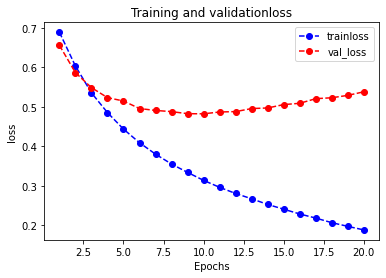

In [29]:
import matplotlib.pyplot as plt

def plot_metric(dfhistory, metric):
    train_metrics = dfhistory[metric]
    val_metrics = dfhistory[f'val_{metric}']
    epochs = range(1, len(train_metrics) + 1)

    plt.plot(epochs, train_metrics, 'bo--')
    plt.plot(epochs, val_metrics, 'ro--')
    plt.title('Training and validation' + metric)

    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend(['train'+metric, 'val_'+metric])
    plt.show()


plot_metric(dfhistory, 'loss')